# Machine Learning Engineer Nanodegree Capstone

In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random
import cv2
import h5py
import pandas as pd

from keras.models import Model
from keras.applications.resnet50 import ResNet50  
from keras.layers import Dense, Dropout, Activation, Flatten, Input, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


In [35]:
t1=time.time()
train_dir = glob.glob('image/train/*/*.jpg')
for src_name in train_dir:
    first_dot = src_name.find('.')
    second_dot = src_name.rfind('.')
#     print(src_name)
#     print(first_dot)
#     print(second_dot)
    name_num = int(src_name[first_dot+1:second_dot])
#     print(name_num)
    dst_name = src_name[0:first_dot+1]+ "{0:05d}".format(name_num) + src_name[second_dot:]
#     print(dst_name)
    os.rename(src_name, dst_name)
t2=time.time()
print(round(t2 - t1, 2), 'seconds to rename !')

14.07 seconds to rename !


## Pre-processing

From https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/ download datasets

``` 
├── image
│   ├── test 
│   │   └── test  [12500 images]
│   ├── train [25000 images]
│   │   ├── cat [12500 images]
│   │   └── dog [12500 images]


```    

In [22]:
t1=time.time()
base_model = ResNet50(input_tensor=Input((224,224,3)), weights='imagenet', include_top=False)
model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

gen = ImageDataGenerator(rescale=1.0/255)
train_generator = gen.flow_from_directory('image/train', target_size=(224,224), shuffle=False,
                                            batch_size=25)
test_generator = gen.flow_from_directory("image/test", target_size=(224,224), shuffle=False, 
                                             batch_size=25, class_mode=None)

# train = model.predict_generator(train_generator, 500) 
# with h5py.File("bottleneck_ResNet50_train.h5") as h:
#     h.create_dataset("train", data=train)
#     h.create_dataset("label", data=train_generator.classes)
    
# test = model.predict_generator(test_generator, 250)
# with h5py.File("bottleneck_ResNet50_test.h5") as h:
#     h.create_dataset("test", data=test)
    
t2=time.time()
print(round(t2 - t1, 2),' seconds')

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
10.64


In [7]:
print(train_generator.filenames[2])

train\cat.10.jpg


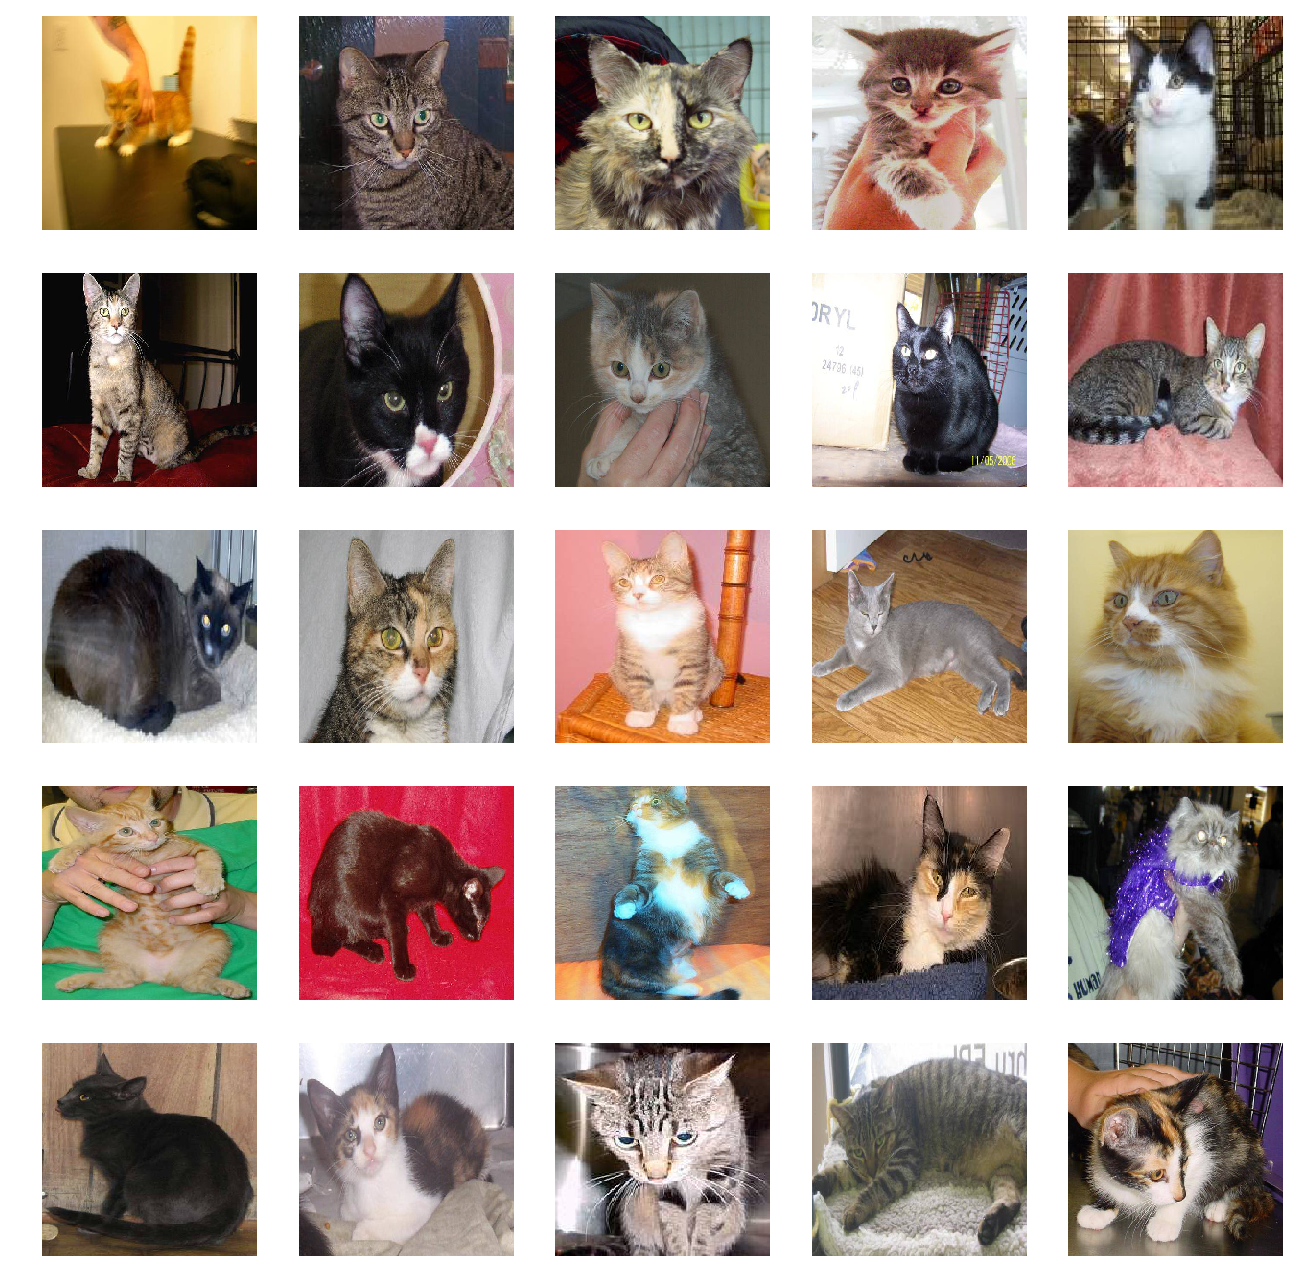

In [10]:
x, y = train_generator.next()

plt.figure(figsize=(16, 16))
for i, (img, label) in enumerate(zip(x, y)):
    
    plt.subplot(5, 5, i+1)
#     if label == 1:
#         plt.title('dog')
#     else:
#         plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

In [65]:
train_feature = []
label = []
test_feature = []

for filename in ["gap_ResNet50.h5", "gap_InceptionV3.h5","gap_Xception.h5"]:
    with h5py.File(filename, 'r') as h:
        train_feature.append(np.array(h['train']))
        test_feature.append(np.array(h['test']))
        label = np.array(h['label'])

train_feature = np.concatenate(train_feature, axis=1)
test_feature = np.concatenate(test_feature, axis=1)

print('train_num: ', len(train_feature))
print('label_num: ', len(label))
print('test_num: ', len(test_feature))

np.random.seed(4)
X_train, y_train = shuffle(train_feature, label)



train_num:  25000
label_num:  25000
test_num:  12500


In [67]:
e = 10
# opt = SGD(lr=0.0001, momentum=0.9)
np.random.seed(4)
input_tensor = Input(X_train.shape[1:])

x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)

my_model = Model(inputs=input_tensor, outputs=x)
my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 'adam'
best_model = ModelCheckpoint('best_model.h5', verbose=0, save_best_only=True)
hist = my_model.fit(X_train, y_train, batch_size=50, epochs=e, validation_split=0.2, callbacks=[best_model, TensorBoard(log_dir='union_tensorlog')])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 6s - loss: 0.0415 - acc: 0.9854 - val_loss: 0.0136 - val_acc: 0.9936
Epoch 2/10
20000/20000 [==============================] - 5s - loss: 0.0201 - acc: 0.9933 - val_loss: 0.0123 - val_acc: 0.9954
Epoch 3/10
20000/20000 [==============================] - 5s - loss: 0.0164 - acc: 0.9941 - val_loss: 0.0135 - val_acc: 0.9936
Epoch 4/10
20000/20000 [==============================] - 5s - loss: 0.0132 - acc: 0.9964 - val_loss: 0.0156 - val_acc: 0.9938
Epoch 5/10
20000/20000 [==============================] - 5s - loss: 0.0123 - acc: 0.9962 - val_loss: 0.0129 - val_acc: 0.9948
Epoch 6/10
20000/20000 [==============================] - 5s - loss: 0.0119 - acc: 0.9965 - val_loss: 0.0130 - val_acc: 0.9948
Epoch 7/10
20000/20000 [==============================] - 5s - loss: 0.0103 - acc: 0.9965 - val_loss: 0.0127 - val_acc: 0.9952
Epoch 8/10
20000/20000 [==============================] - 5s -

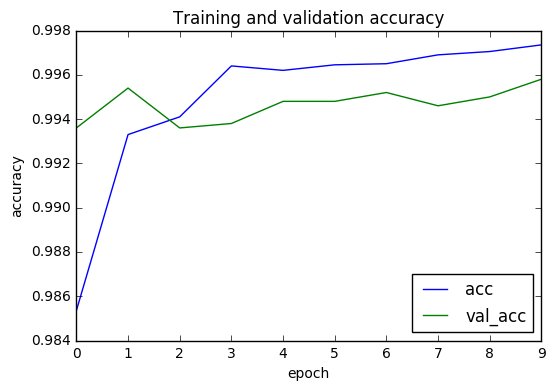

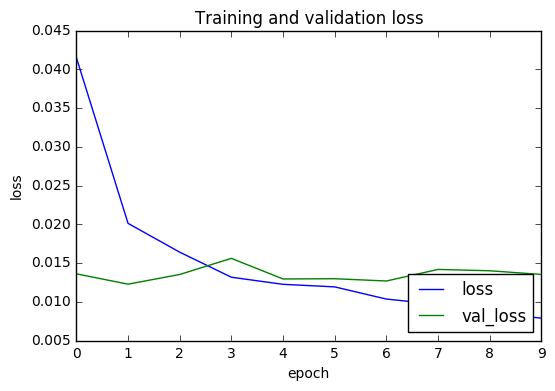

In [16]:

# plt.axis((0,e,-0.5,1.1))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Training and validation accuracy')
plt.legend(['acc', 'val_acc' ], loc='lower right')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.figure()

# plt.axis((0,e,-0.5,1.1))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='lower right')  

plt.show()

In [ ]:
y_pred = my_model.predict(train_feature, verbose=1)

In [70]:
cat_abnormal = []
dog_abnormal = []
train_normal = []
label_normal = []

for i in range(0,len(X_train)):
    if label[i]==0 and y_pred[i]>0.6:
        cat_abnormal.append(train_generator.filenames[i])
    elif label[i]==1 and y_pred[i]<0.8:
        dog_abnormal.append(train_generator.filenames[i])
    else:
        train_normal.append(train_feature[i])
        label_normal.append(label[i])

In [71]:
cat_abnormal = np.asarray(cat_abnormal)
dog_abnormal = np.asarray(dog_abnormal)
print(len(cat_abnormal), cat_abnormal)
print(len(dog_abnormal), dog_abnormal)

19 ['cat\\cat.10270.jpg' 'cat\\cat.10625.jpg' 'cat\\cat.11399.jpg'
 'cat\\cat.12493.jpg' 'cat\\cat.1575.jpg' 'cat\\cat.252.jpg'
 'cat\\cat.3123.jpg' 'cat\\cat.372.jpg' 'cat\\cat.3731.jpg'
 'cat\\cat.3871.jpg' 'cat\\cat.4085.jpg' 'cat\\cat.5241.jpg'
 'cat\\cat.6655.jpg' 'cat\\cat.7377.jpg' 'cat\\cat.7730.jpg'
 'cat\\cat.7738.jpg' 'cat\\cat.7968.jpg' 'cat\\cat.9263.jpg'
 'cat\\cat.9882.jpg']
14 ['dog\\dog.10155.jpg' 'dog\\dog.10179.jpg' 'dog\\dog.10871.jpg'
 'dog\\dog.11731.jpg' 'dog\\dog.4334.jpg' 'dog\\dog.5529.jpg'
 'dog\\dog.5604.jpg' 'dog\\dog.6457.jpg' 'dog\\dog.651.jpg'
 'dog\\dog.6921.jpg' 'dog\\dog.7332.jpg' 'dog\\dog.8444.jpg'
 'dog\\dog.8736.jpg' 'dog\\dog.881.jpg']


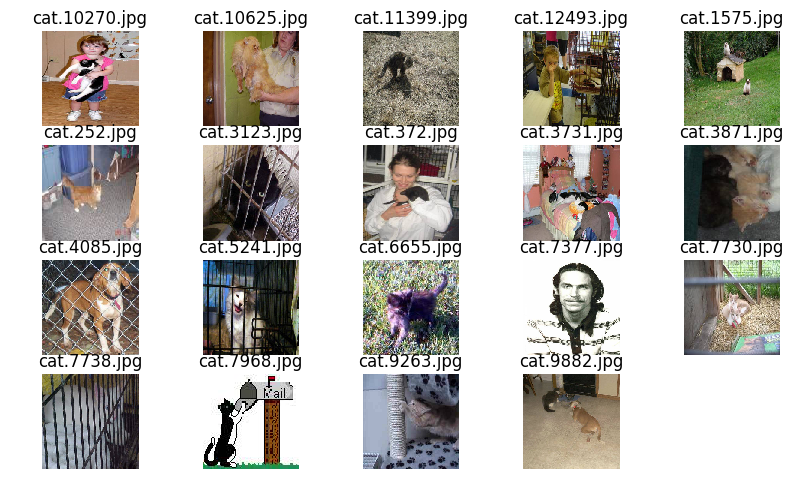

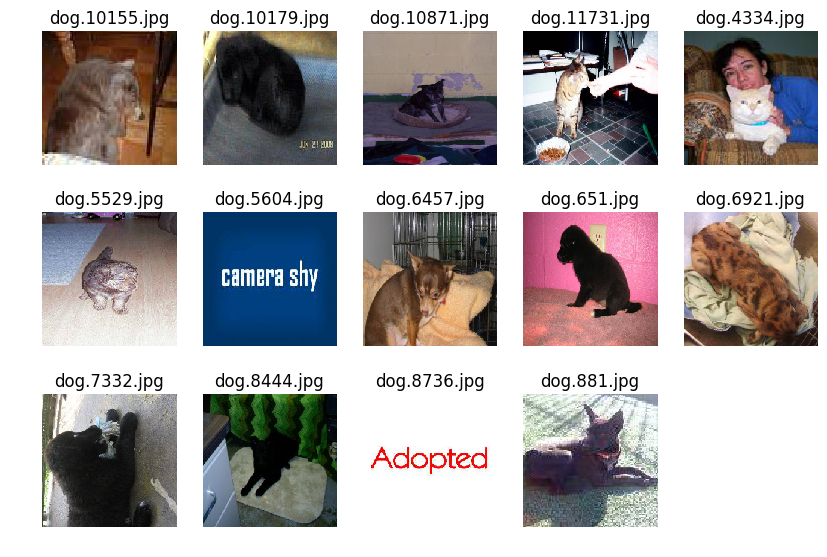

In [72]:
plt.figure(figsize=(10, 16))
for i in range(0,len(cat_abnormal)):
    plt.subplot(11, 5, i+1)
    cat_name = 'image/train/' + cat_abnormal[i]
    img = image.load_img(cat_name,target_size=(224,224))
    plt.axis('off')
    plt.title(cat_name[cat_name.rfind('\\')+1:])
    plt.imshow(img, interpolation="nearest")
    
plt.figure(figsize=(10, 16))    
for i in range(0,len(dog_abnormal)):
    plt.subplot(7, 5, i+1)
    dog_name = 'image/train/' + dog_abnormal[i]
    img = image.load_img(dog_name,target_size=(224,224))
    plt.title(dog_name[dog_name.rfind('\\')+1:])
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

In [73]:
train_normal = np.asarray(train_normal)
label_normal = np.asarray(label_normal)
print(len(train_normal))

np.random.seed(4)
X_train_2, y_train_2 = shuffle(train_normal, label_normal)


24967


In [74]:
e = 10

np.random.seed(4)
input_tensor = Input(X_train_2.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)

my_model_2 = Model(inputs=input_tensor, outputs=x)
my_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 'adam'
best_model_2 = ModelCheckpoint('best_model_2.h5', verbose=0, save_best_only=True)
hist = my_model_2.fit(X_train_2, y_train_2, batch_size=50, epochs=e, validation_split=0.2, callbacks=[best_model_2, TensorBoard(log_dir='union_tensorlog')])

Train on 19973 samples, validate on 4994 samples
Epoch 1/10
19973/19973 [==============================] - 6s - loss: 0.0356 - acc: 0.9872 - val_loss: 0.0145 - val_acc: 0.9952
Epoch 2/10
19973/19973 [==============================] - 5s - loss: 0.0157 - acc: 0.9948 - val_loss: 0.0140 - val_acc: 0.9946
Epoch 3/10
19973/19973 [==============================] - 6s - loss: 0.0113 - acc: 0.9956 - val_loss: 0.0115 - val_acc: 0.9956
Epoch 4/10
19973/19973 [==============================] - 4s - loss: 0.0098 - acc: 0.9964 - val_loss: 0.0154 - val_acc: 0.9942
Epoch 5/10
19973/19973 [==============================] - 5s - loss: 0.0068 - acc: 0.9982 - val_loss: 0.0124 - val_acc: 0.9960
Epoch 6/10
19973/19973 [==============================] - 5s - loss: 0.0065 - acc: 0.9977 - val_loss: 0.0116 - val_acc: 0.9952
Epoch 7/10
19973/19973 [==============================] - 5s - loss: 0.0064 - acc: 0.9974 - val_loss: 0.0113 - val_acc: 0.9952
Epoch 8/10
19973/19973 [==============================] - 5s -

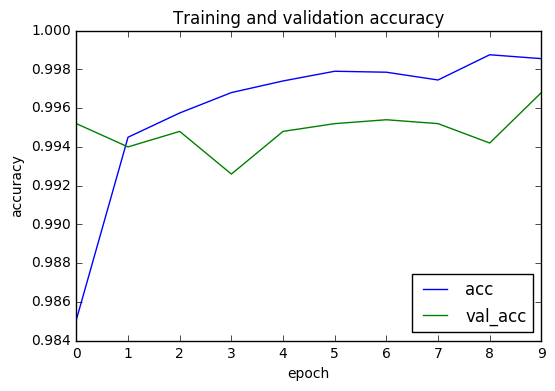

In [34]:
# plt.axis((0,e,-0.5,1.1))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Training and validation accuracy')
plt.legend(['acc', 'val_acc' ], loc='lower right')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.figure()

# plt.axis((0,e,-0.5,1.1))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='lower right')  

plt.show()

In [84]:
y_pred_2 = my_model_2.predict(test_feature, verbose=1)
y_pred_2 = y_pred_2.clip(min=0.005, max=0.995)

12192/12500 [============================>.] - ETA: 0s

In [76]:
import pandas as pd
df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("image/test/", target_size=(224,224), shuffle=False, 
                                             batch_size=50, class_mode=None)
for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('test')+5:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred_2[i])

df.to_csv('submission_union_2.csv', index=None)

Found 12500 images belonging to 1 classes.


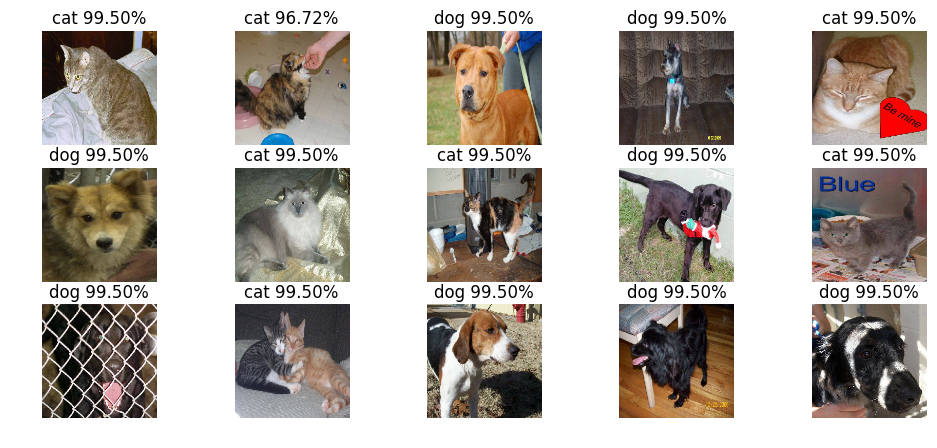

In [90]:

plt.figure(figsize=(12, 5))
for i in range(15):
    x = random.randint(1, len(test_feature))
    prediction = y_pred_2[x]
    test_name = 'image/test/' + test_generator.filenames[x]
    img = image.load_img(test_name,target_size=(224,224))
    
    plt.subplot(3, 5, i+1)
    
    if prediction < 0.5:
        
        plt.title("cat {:.2f}%".format(100 - float(prediction)*100))
    else:
        plt.title("dog {:.2f}%".format(float(prediction)*100))
    
    plt.axis('off')
    plt.imshow(img) 